# INVESTMENTS ANALYSIS: USA vs. JAP

![MAIN](https://media4.giphy.com/media/67ThRZlYBvibtdF9JH/giphy.gif)

    1. Hypothesis
    2. Getting the data
        2.1. Historic data values for specific symbold
        2.2. Historic USA PIB
        2.3. Historic JAP PIB
    3. Load the data into SQL
    4. Extracting data from SQL
    5. Analyzing the data
        5.1. Correllation Analysis
        5.2. Historic evolution
        5.3. Distribution analysis
    6. Running expermients
    7. Conlusion     

# Hypothesis

USA market is more attractive for investors than JPN one. 

For this hypothesis we are going to see:

    1. PIB historical results for each country
    2. Historical Index results related to most valuables companies: S&P 500 for US, JPXN for JPN
    3. Historical stock value results for a big retail company: AMZN for US, SEVEN for JPN

## Getting the data

In [2]:
import modularization as md
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import norm

### Historic daily values for specific symbols

In [3]:
df = md.getSymbols_df() #Passed symbols: amzn, spy, 3382.t and jpxn

symbol amzn appended correctly to the desired list. Proceed providing a nee one, or write "DONE" if finish.
symbol spy appended correctly to the desired list. Proceed providing a nee one, or write "DONE" if finish.
symbol jpxn appended correctly to the desired list. Proceed providing a nee one, or write "DONE" if finish.
symbol 3382.t appended correctly to the desired list. Proceed providing a nee one, or write "DONE" if finish.
[*********************100%***********************]  4 of 4 completed


### Getting historic USA PIB

In [4]:
usa_hist_pib = md.get_usa_pib()

### Getting historic JAP PIB

In [5]:
jap_hist_pib = md.get_jap_pib()

## Loading the data into SQL

In [6]:
md.load_to_sql(usa_hist_pib, jap_hist_pib, df)

In [7]:
#Below code has been deprecated accordingly to the warning. Thus, I need to run this on the workbench environment

#engine.execute("""ALTER TABLE `financials`.`pib` 
#CHANGE COLUMN `pib_value_usa` `pib_value_usa` BIGINT NULL DEFAULT NULL""")
#engine.execute("""ALTER TABLE `financials`.`pib` 
#CHANGE COLUMN `pib_value_jap` `pib_value_jap` BIGINT NULL DEFAULT NULL""")
#engine.execute("""ALTER TABLE `financials`.`pib` 
#CHANGE COLUMN `index` `index` BIGINT NOT NULL
#""")

## Extracting data with SQL

In [8]:
q_yearly = """SELECT YEAR(Date) AS year
	,pib_value_usa
    ,pib_value_jap
	,MAX(Seven) AS seven
    ,MAX(AMZN) AS amzn
    ,MAX(JPXN) AS jpxn
    ,MAX(SPY) AS spy
FROM usa_jap
	LEFT JOIN pib ON YEAR(usa_jap.Date) = YEAR(pib.year)
WHERE WEEK(Date) = 52
GROUP BY 1, 2, 3;"""

In [9]:
q_weekly = """SELECT WEEK(Date) AS week
	,YEAR(Date) AS year
    ,Date
	,pib_value_usa 
    ,pib_value_jap
	,MAX(Seven) AS seven
    ,MAX(AMZN) AS amzn
    ,MAX(JPXN) AS jpxn
    ,MAX(SPY) AS spy
FROM usa_jap
	LEFT JOIN pib ON YEAR(usa_jap.Date) = YEAR(pib.year)
GROUP BY 1, 2, 3, 4, 5;"""

In [10]:
engine = md.financial_wb_connection(md.getpass())

In [11]:
yearly_data = pd.read_sql_query(q_yearly, engine)
weekly_data = pd.read_sql_query(q_weekly, engine)
yearly_data =  md.year_w_YoY(yearly_data)
weekly_data = md.week_w_YoY(weekly_data)
yearly_data_2000 = yearly_data[yearly_data['year'] > 2000]

## Analyzing the data

### Correllation Analysis

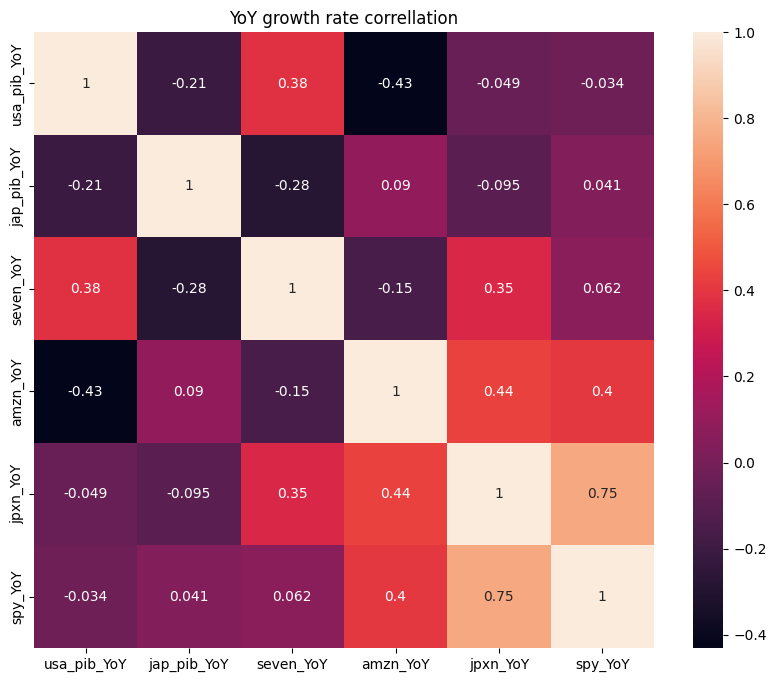

In [13]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(yearly_data_2000.drop(['year', 'pib_value_usa', 'pib_value_jap', 'seven', 'amzn', 'jpxn', 'spy'], axis=1).corr(), annot=True)
plt.title('YoY growth rate correllation')
fig.savefig('Images/1. YoY growth rates correllation.png')

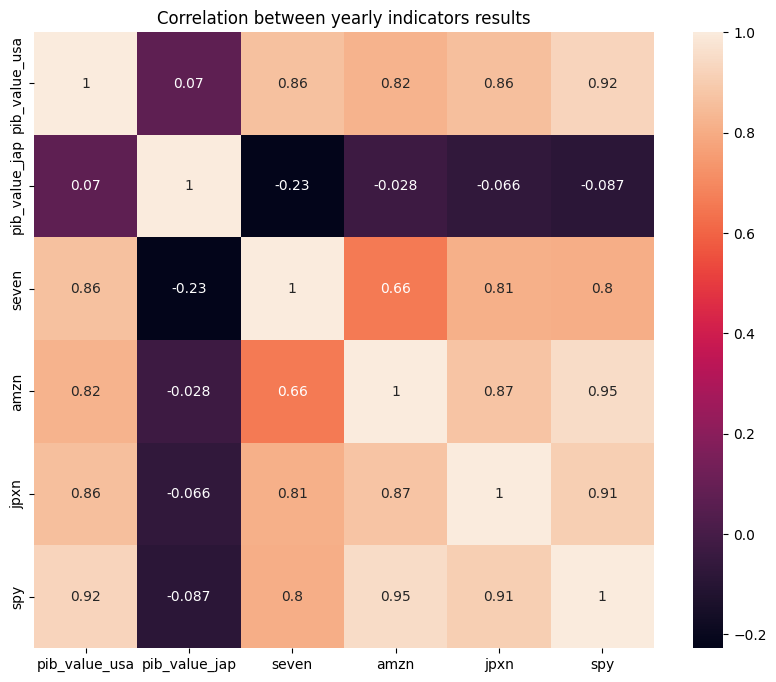

In [14]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(yearly_data_2000.drop(['year', 'usa_pib_YoY', 'jap_pib_YoY', 'seven_YoY', 'amzn_YoY', 'jpxn_YoY', 'spy_YoY'], axis=1).corr(), annot=True)
plt.title('Correlation between yearly indicators results')
fig.savefig('Images/2. Yearly results crrellation.png')

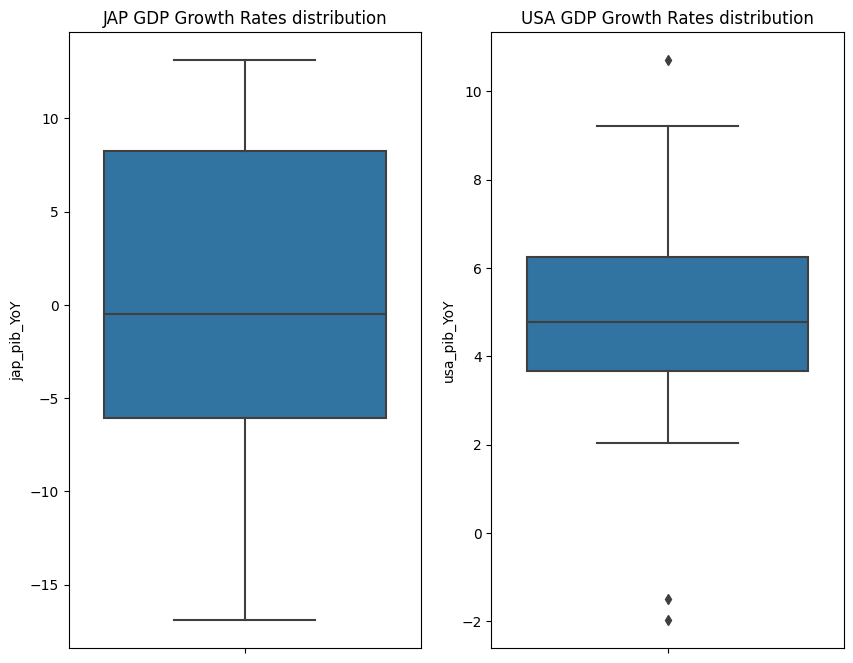

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
gdp_data = yearly_data[['year', 'jap_pib_YoY', 'usa_pib_YoY']]
fig1 = sns.boxplot(y=gdp_data['jap_pib_YoY'], ax=axs[0])
fig1.set(title='JAP GDP Growth Rates distribution')
fig2 = sns.boxplot(y=gdp_data['usa_pib_YoY'], ax=axs[1])
fig2.set(title='USA GDP Growth Rates distribution')

fig.savefig('Images/3. US and JAP GDP YoY growth distribution.png')

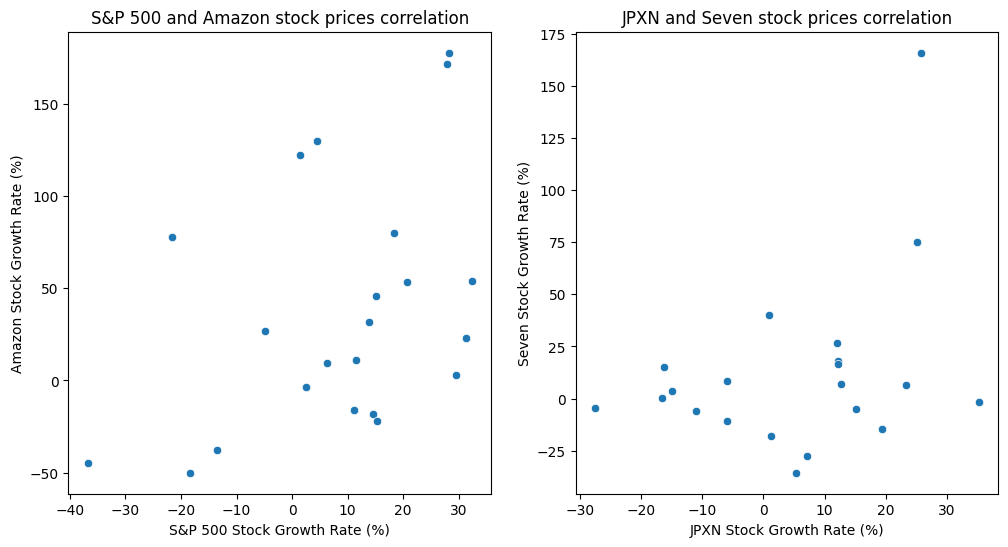

In [16]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
gdp_data = yearly_data_2000[['year', 'amzn_YoY', 'spy_YoY']]
fig1 = sns.scatterplot(x=gdp_data['spy_YoY'], y=gdp_data['amzn_YoY'], ax=axs[0])
fig1.set(title='S&P 500 and Amazon stock prices correlation')
fig1.set(xlabel='S&P 500 Stock Growth Rate (%)')
fig1.set(ylabel='Amazon Stock Growth Rate (%)')

gdp_data = yearly_data_2000[['year', 'seven_YoY', 'jpxn_YoY']]
fig2 = sns.scatterplot(x=gdp_data['jpxn_YoY'], y=gdp_data['seven_YoY'], ax=axs[1])
fig2.set(title='JPXN and Seven stock prices correlation')
fig2.set(xlabel='JPXN Stock Growth Rate (%)')
fig2.set(ylabel='Seven Stock Growth Rate (%)')
plt.show()
fig.savefig('Images/4. JAP and US retail comp and ETF corr.png')


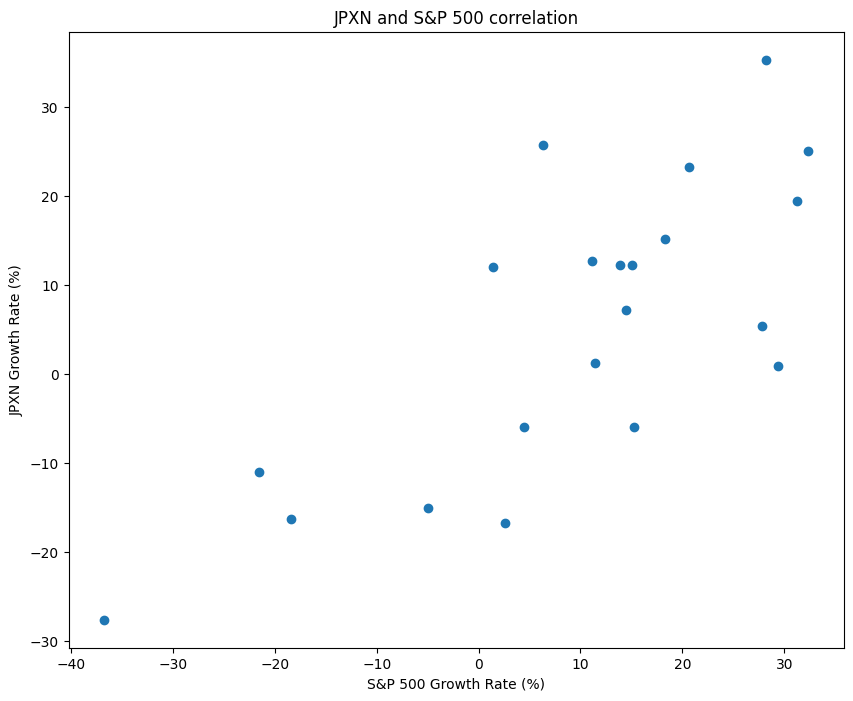

In [17]:
fig = plt.figure(figsize=(10,8))
gdp_data = yearly_data_2000[['year', 'spy_YoY', 'jpxn_YoY']]
plt.scatter(x=gdp_data['spy_YoY'], y=gdp_data['jpxn_YoY'])
plt.title('JPXN and S&P 500 correlation')
plt.xlabel('S&P 500 Growth Rate (%)')
plt.ylabel('JPXN Growth Rate (%)')
plt.show()
fig.savefig('Images/5. JPXN and SPY correllation.png')

## Historic evolution

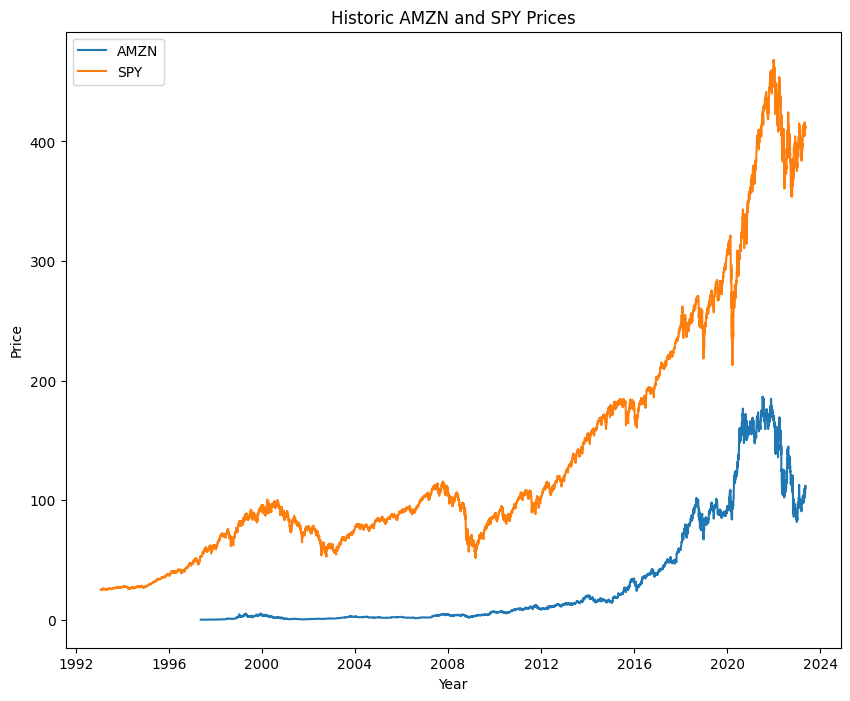

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
amzn_spy = weekly_data[['Date', 'amzn', 'spy']]

# Plot daily prices for AMZN and SPY
sns.lineplot(data=amzn_spy, x='Date', y='amzn', ax=ax, label='AMZN')
sns.lineplot(data=amzn_spy, x='Date', y='spy', ax=ax, label='SPY')
plt.title('Historic AMZN and SPY Prices')
plt.xlabel('Year')
plt.ylabel('Price')
fig.savefig('Images/6. AMZN and SPY historic evolution.png')

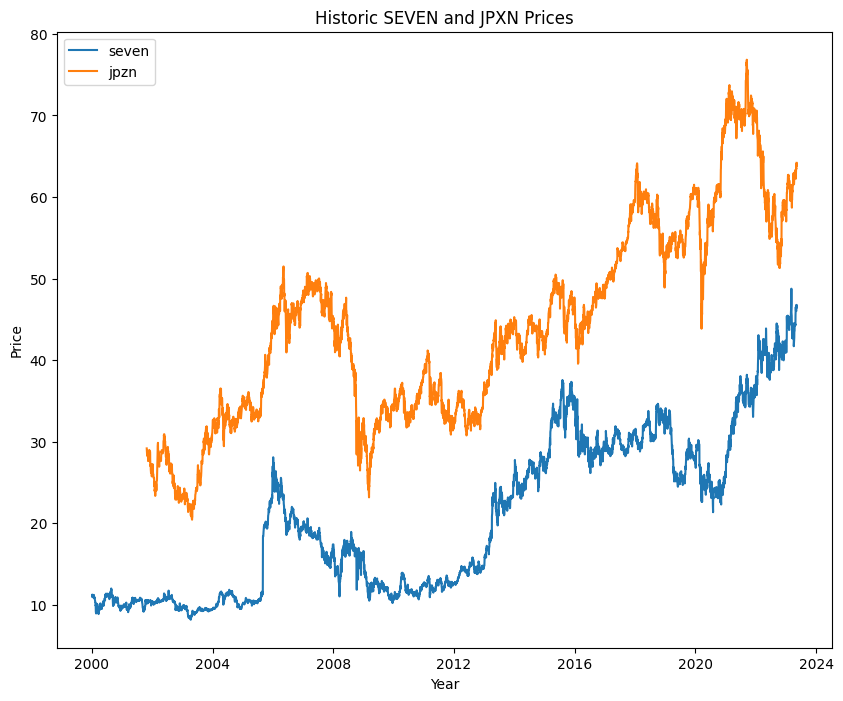

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
amzn_spy = weekly_data[['Date', 'seven', 'jpxn']]

# Plot daily prices for AMZN and SPY
sns.lineplot(data=weekly_data, x='Date', y='seven', ax=ax, label='seven')
sns.lineplot(data=weekly_data, x='Date', y='jpxn', ax=ax, label='jpzn')
plt.title('Historic SEVEN and JPXN Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()
fig.savefig('Images/7. SEVEN and JPXN historic evolution.png')

## Distribution analysis

In [27]:
p_spy_increase = yearly_data_2000[yearly_data_2000['spy_YoY'] > 0]['spy_YoY'].count()/yearly_data_2000['spy_YoY'].count()
p_jpxn_increase = yearly_data_2000[yearly_data_2000['jpxn_YoY'] > 0]['jpxn_YoY'].count()/yearly_data_2000['jpxn_YoY'].count()
p_amzn_increase = yearly_data_2000[yearly_data_2000['amzn_YoY'] > 0]['amzn_YoY'].count()/yearly_data_2000['amzn_YoY'].count()
p_seven_increase = yearly_data_2000[yearly_data_2000['seven_YoY'] > 0]['seven_YoY'].count()/yearly_data_2000['seven_YoY'].count()
spy_mean = yearly_data_2000['spy_YoY'].mean()
amzn_mean = yearly_data_2000['amzn'].mean()
jpxn_mean = yearly_data_2000['jpxn_YoY'].mean()
seven_mean = yearly_data_2000['seven_YoY'].mean()
spy_std = yearly_data_2000['spy_YoY'].std()
amzn_std = yearly_data_2000['amzn'].std()
jpxn_std = yearly_data_2000['jpxn_YoY'].std()
seven_std = yearly_data_2000['seven_YoY'].std()

In [41]:
indicators = pd.DataFrame({'p_increase': [p_spy_increase, p_jpxn_increase, p_amzn_increase, p_seven_increase]
              ,'mean': [spy_mean, amzn_mean, jpxn_mean, seven_mean]
              ,'std': [spy_std, amzn_std, jpxn_std, seven_std]})
indicators = indicators.rename(index={0:'spy', 1:'amzn', 2:'jpxn', 3:'seven'})
indicators

,p_increase,mean,std
spy,0.772727,8.585477,18.444758
amzn,0.666667,36.985637,51.337320
jpxn,0.681818,5.208503,16.614891
seven,0.590909,12.031603,41.435591


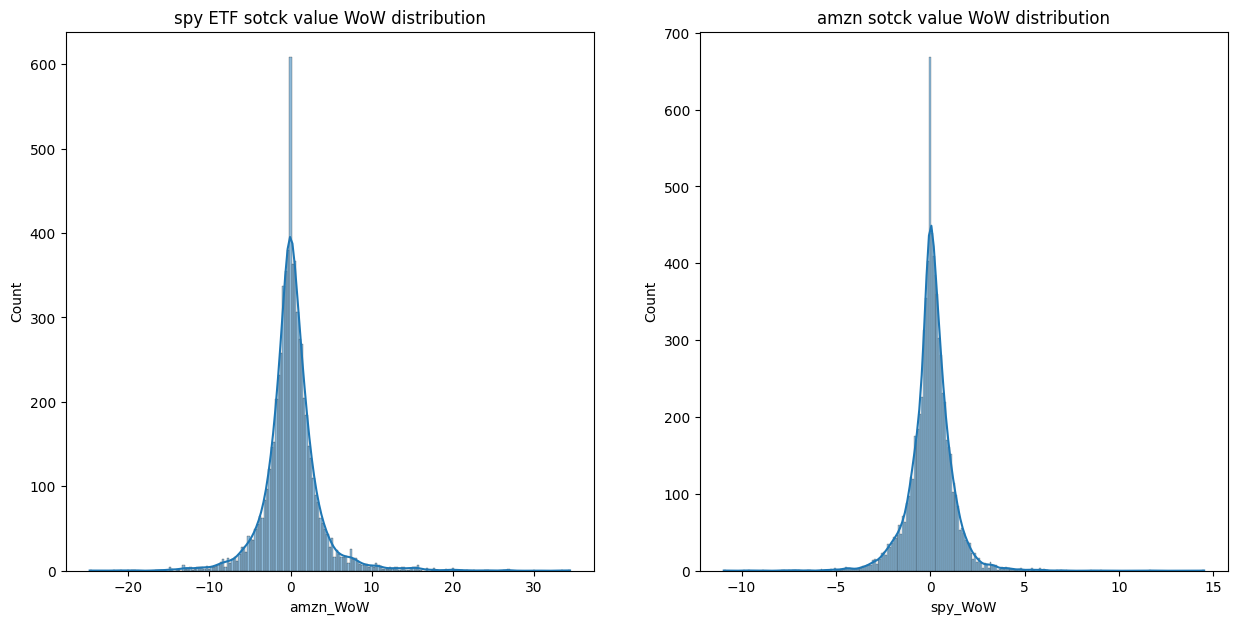

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

graf1 = sns.histplot(data=weekly_data, x='amzn_WoW', ax=axs[0], kde=True).set(title='spy ETF sotck value WoW distribution')
graf2 = sns.histplot(data=weekly_data, x='spy_WoW', ax=axs[1], kde=True).set(title='amzn sotck value WoW distribution')

fig.savefig('Images/8. SPY and AMZN WoW growth rate distributionn.png')

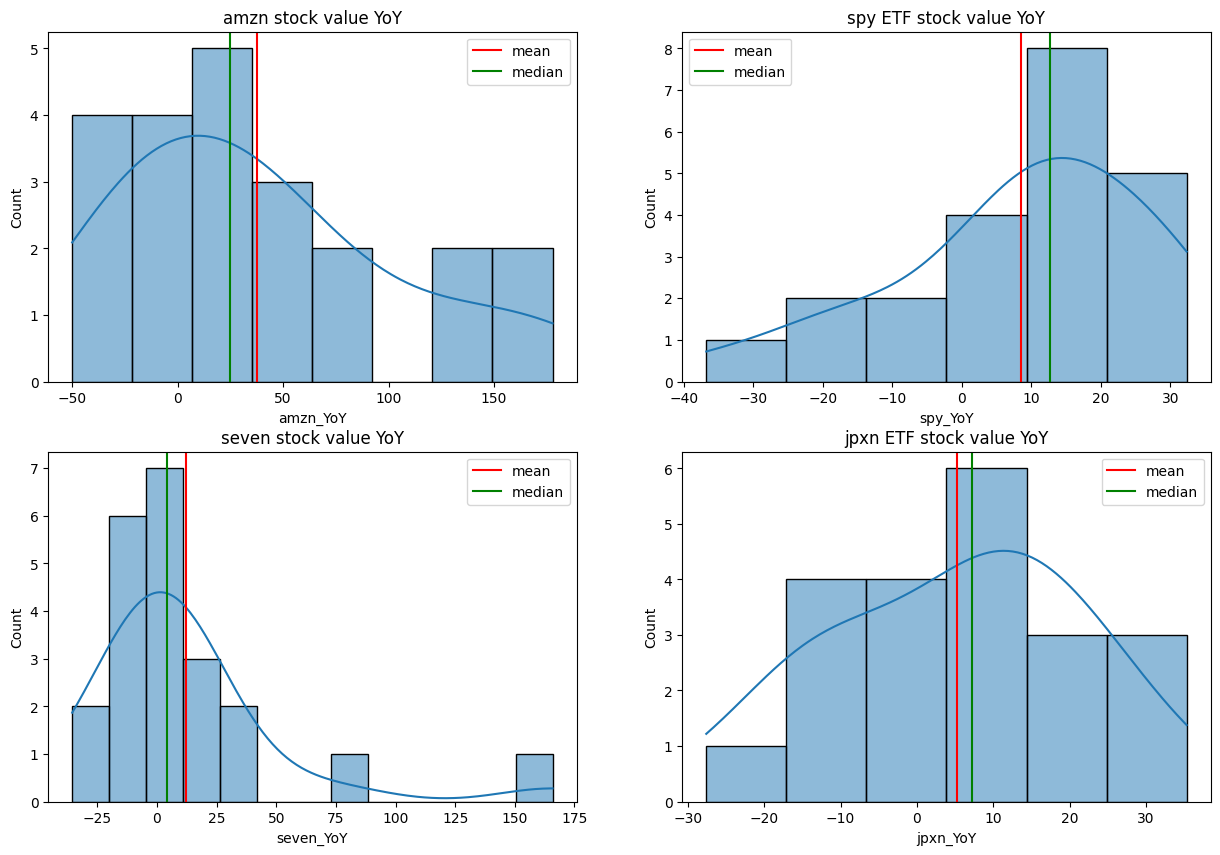

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

graf1 = sns.histplot(data=yearly_data_2000, x='amzn_YoY', kde=True, ax=axs[0][0], bins=8)
graf1.axvline(x=yearly_data_2000['amzn_YoY'].mean(), c="red", label="mean")
graf1.axvline(x=yearly_data_2000['amzn_YoY'].median(), c="green", label="median")
graf1.set(title='amzn stock value YoY')
graf1.legend()

graf2 = sns.histplot(data=yearly_data_2000, x='spy_YoY', kde=True, ax=axs[0][1])
graf2.axvline(x=yearly_data_2000['spy_YoY'].mean(), c="red", label="mean")
graf2.axvline(x=yearly_data_2000['spy_YoY'].median(), c="green", label="median")
graf2.set(title='spy ETF stock value YoY')
graf2.legend()

graf3 = sns.histplot(data=yearly_data_2000, x='jpxn_YoY', kde=True, ax=axs[1][1])
graf3.axvline(x=yearly_data_2000['jpxn_YoY'].mean(), c="red", label="mean")
graf3.axvline(x=yearly_data_2000['jpxn_YoY'].median(), c="green", label="median")
graf3.set(title='jpxn ETF stock value YoY')
graf3.legend()

graf4 = sns.histplot(data=yearly_data_2000, x='seven_YoY', kde=True, ax=axs[1][0])
graf4.axvline(x=yearly_data_2000['seven_YoY'].mean(), c="red", label="mean")
graf4.axvline(x=yearly_data_2000['seven_YoY'].median(), c="green", label="median")
graf4.set(title='seven stock value YoY')
graf4.legend()

fig.savefig('Images/9. stock values YoY growth rate distribution.png')

In [46]:
#This will help me calculate the p_ of seeing an icrease WoW on this stocks for 2 consecutives weeks

weekly_data['amzn_prev_w_val'] = weekly_data['amzn_WoW'].shift(1)
weekly_data['spy_prev_w_val'] = weekly_data['spy_WoW'].shift(1)

In [51]:
inc_2w = weekly_data[(weekly_data['amzn_prev_w_val'] > 0) & (weekly_data['amzn_WoW'] > 0)]
inc_1w = weekly_data[(weekly_data['amzn_prev_w_val'] < 0) & (weekly_data['amzn_WoW'] > 0)]
dec_2w = weekly_data[(weekly_data['amzn_prev_w_val'] < 0) & (weekly_data['amzn_WoW'] < 0)]
dec_1w = weekly_data[(weekly_data['amzn_prev_w_val'] > 0) & (weekly_data['amzn_WoW'] < 0)]

consec_dec_inc = {'inc_2w': len(inc_2w), 'inc_1w':len(inc_1w), 'dec_1w':len(dec_1w), 'dec_2w':len(dec_2w)}
consec_dec_inc

#Since this is euqally distributed, I'm not using this for any analysis

{'inc_2w': 1625, 'inc_1w': 1577, 'dec_1w': 1576, 'dec_2w': 1504}

## Running experminets

In [28]:
amzn_norm = norm(amzn_mean, amzn_std)
spy_norm = norm(spy_mean, spy_std)
jpxn_norm = norm(jpxn_mean, jpxn_std)
seven_norm = norm(seven_mean, seven_std)

In [29]:
amzn_sample = amzn_norm.rvs(1000)
spy_sample = spy_norm.rvs(1000)
jpxn_sample = jpxn_norm.rvs(1000)
seven_sample = seven_norm.rvs(1000)

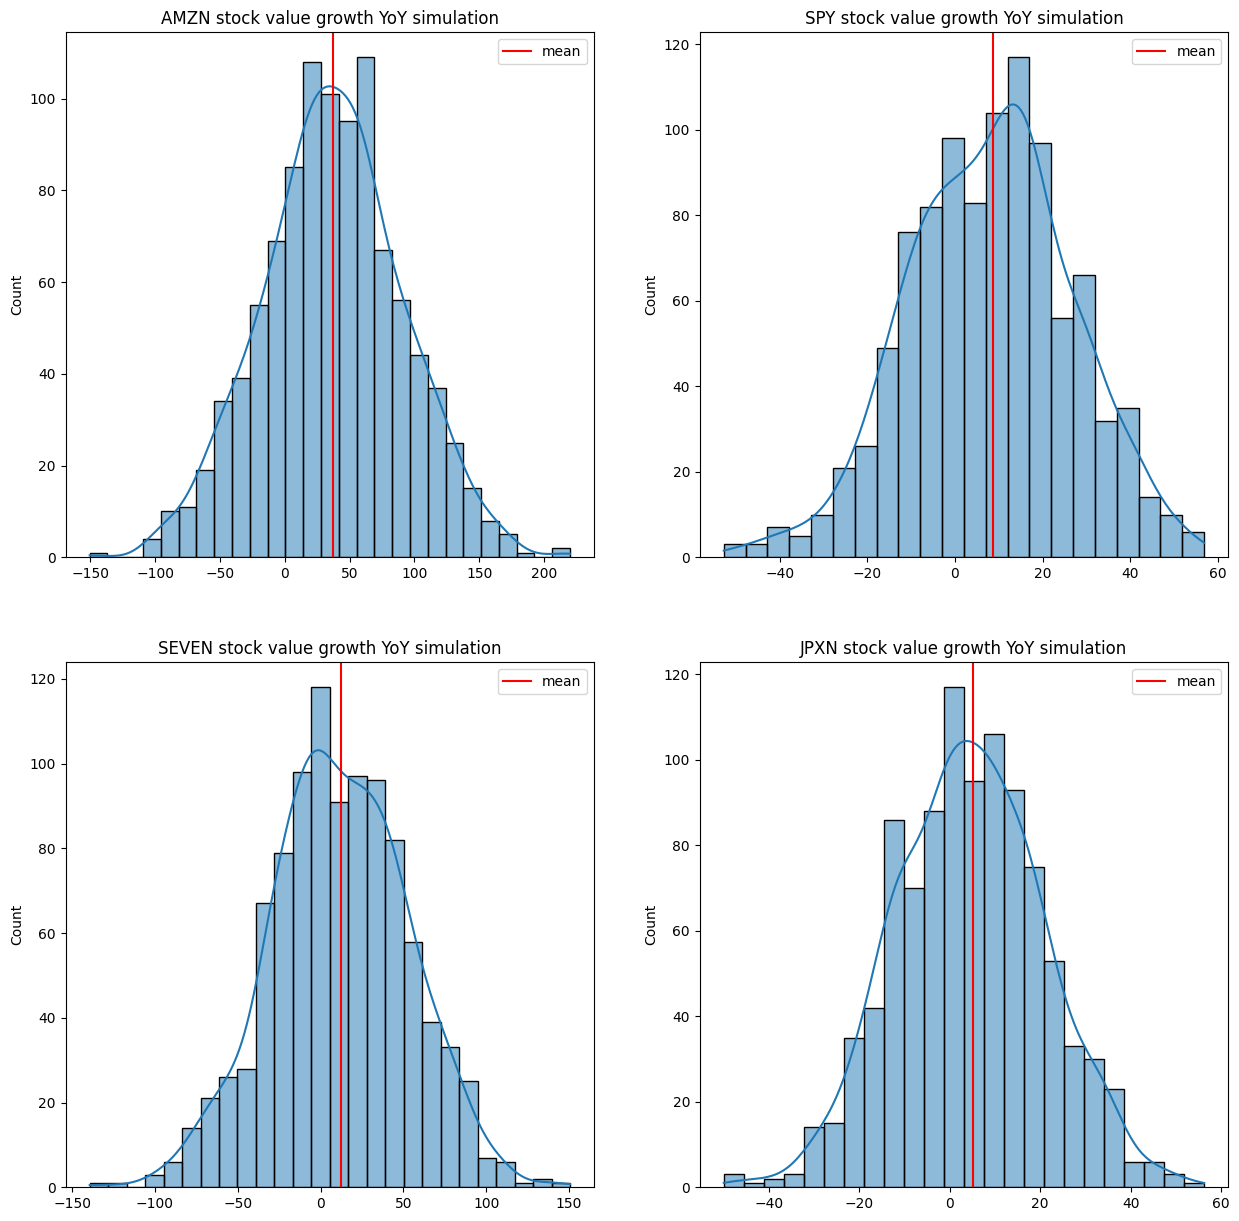

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

graf1 = sns.histplot(x=amzn_sample, kde=True, ax=axs[0][0])
graf1.axvline(x=amzn_mean, c="red", label="mean")
graf1.set(title='AMZN stock value growth YoY simulation')
graf1.legend()

graf2 = sns.histplot(x=spy_sample, kde=True, ax=axs[0][1])
graf2.axvline(x=spy_mean, c="red", label="mean")
graf2.set(title='SPY stock value growth YoY simulation')
graf2.legend()

graf3 = sns.histplot(x=seven_sample, kde=True, ax=axs[1][0])
graf3.axvline(x=seven_mean, c="red", label="mean")
graf3.set(title='SEVEN stock value growth YoY simulation')
graf3.legend()

graf4 = sns.histplot(x=jpxn_sample, kde=True, ax=axs[1][1])
graf4.axvline(x=jpxn_mean, c="red", label="mean")
graf4.set(title='JPXN stock value growth YoY simulation')
graf4.legend()

fig.savefig('Images/10. Experiment distribution.png')

## Conclusions

    1. GDP growth rate US vs. JAP: US PIB is more stable and almost always possitive (2-11) while JAP is more volatil (-15;10). There is no correllation between the PIB growth of both countries.

    2. amzn and S&P 500 YoY growth have a stronger correllation than seven and JPXN YoY growth (0.4 vs. 0.35).

    3. There is a considerable high correllation between S&P 500 and JPXN YoY growth (0.77). 

    4. seven has been reaching multiple times (6) new historic max values during the last 3 years. amzn is recovering from post-pandemic values. Right now it's at pre-pandemic value.

    5. S&P 500 is the stock with a considerable low std (16) and quite high YoY growth mean (8%) making it the most attractive active to invest.
     
    6. amzn is the stock with the highest YoY growth mean (33%), but as well with a considerable high std (51) making it a most risky investment.